In [1]:
import numpy as np
import pandas as pd
import glob
import os  
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import seaborn as sns

import keras
from keras import initializers
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dropout, Dense
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize

from keras import models
from keras.models import load_model
from keras.layers import Dropout
from keras.layers import BatchNormalization

from keras.optimizers import SGD, Adam, Adagrad, RMSprop, Adadelta, Nadam
from adabound import AdaBound
from group_norm import GroupNormalization

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils.np_utils import to_categorical

from PIL import Image, ImageFile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Using TensorFlow backend.


In [2]:
path, dirs, files = next(os.walk(r"C:\\Users\\Tony\\Desktop\\Summer\\boat_classification\\data_aug2"))
dirs

['buoy',
 'cruise ship',
 'ferry boat',
 'freight boat',
 'gondola',
 'inflatable boat',
 'kayak',
 'paper boat',
 'sailboat']

In [3]:
class_label = ['buoy',
 'cruise ship',
 'ferry boat',
 'freight boat',
 'gondola',
 'inflatable boat',
 'kayak',
 'paper boat',
 'sailboat']

In [4]:
# Read in the augmented dataset
i = 0

X_data = []
Y_data = []

for boat in class_label:
    files = glob.glob (r"C:\\Users\\Tony\\Desktop\\Summer\\boat_classification\data_aug2\\" + str(boat) + "/*.jpg")
    
    for myFile in files:
      img = Image.open(myFile)
      #img.thumbnail((width, height), Image.ANTIALIAS) # resizes image in-place keeps ratio
      img = img.resize((128,128), Image.ANTIALIAS) # resizes image without ratio
      img = np.array(img)

      if img.shape == (128, 128, 3):
        # Add the numpy image to matrix with all data
        X_data.append (img)
        Y_data.append (i)
        
    i += 1

Total Number of Samples:  3852
Number of Samples per Class after Augmentation:
buoy : 402
cruise ship : 475
ferry boat : 398
freight boat : 345
gondola : 480
inflatable boat : 331
kayak : 502
paper boat : 432
sailboat : 487


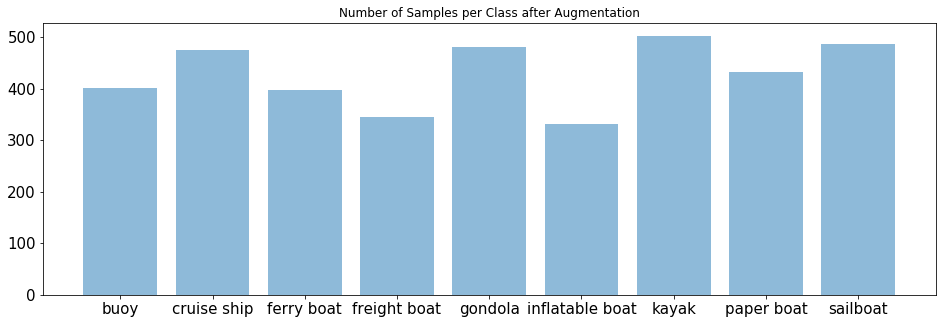

In [5]:
X = np.array(X_data)
Y = np.array(Y_data)
# Print shapes to see if they are correct
# print(X.shape)
# print(Y.shape)

number_classes = [0,0,0,0,0,0,0,0,0]

for i in range(len(Y)):
    if (Y[i] == 0):
        number_classes[0] += 1
    elif (Y[i] == 1):
        number_classes[1] += 1
    elif (Y[i] == 2):
        number_classes[2] += 1
    elif (Y[i] == 3):
        number_classes[3] += 1
    elif (Y[i] == 4):
        number_classes[4] += 1
    elif (Y[i] == 5):
        number_classes[5] += 1
    elif (Y[i] == 6):
        number_classes[6] += 1
    elif (Y[i] == 7):
        number_classes[7] += 1
    elif (Y[i] == 8):
        number_classes[8] += 1
    elif (Y[i] == 9):
        number_classes[9] += 1

print("Total Number of Samples: ", len(X))
print("Number of Samples per Class after Augmentation:")  

for i in range(len(class_label)):
     print(class_label[i], ":", number_classes[i])

objects = class_label
y_pos = np.arange(len(objects))
samples = number_classes

plt.figure(figsize=[16,5])
plt.bar(y_pos, samples, align='center', alpha=0.5)
plt.xticks(y_pos, objects, size=15)
plt.yticks(size=15)
plt.title('Number of Samples per Class after Augmentation')

plt.show()

In [6]:
# Normalizing the Data
# y = (x - x.min) / (x.max - x.min)

x_min = X.min(axis=(1, 2), keepdims=True)
x_max = X.max(axis=(1, 2), keepdims=True)
X = (X-x_min) / (x_max-x_min)

In [7]:
validation_datagen = ImageDataGenerator()

test_datagen = ImageDataGenerator()

train_datagen = ImageDataGenerator(
#         rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
#         fill_mode='nearest',
#         featurewise_center=True,
#         featurewise_std_normalization=True,
#         zca_whitening=True, 
#         zca_epsilon=1e-06
        )

In [8]:
y_cat = to_categorical(Y_data, len(class_label))

In [9]:
model = Sequential()
model.add(Conv2D(128, (5, 5), input_shape=(128, 128, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(GroupNormalization(groups=32, axis=-1))
# model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(GroupNormalization(groups=32, axis=-1))
# model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(GroupNormalization(groups=32, axis=-1))
# model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, kernel_initializer=initializers.glorot_uniform(seed=0), activation='relu'))
model.add(Dense(9, kernel_initializer=initializers.glorot_uniform(seed=0), activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 124, 124, 128)     9728      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
group_normalization_1 (Group (None, 62, 62, 128)       256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
group_normalization_2 (Group (None, 30, 30, 64)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        18464     
__________

In [10]:
model.compile(optimizer=Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0), 
              loss='categorical_crossentropy', metrics=['acc'])

In [11]:
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y_cat, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.2)

X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

Number of Samples Train:  3081
Number of Samples Validation:  616
Number of Samples Test:  155


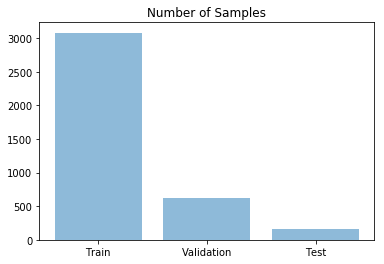

In [12]:
objects = ('Train', 'Validation', 'Test')
y_pos = np.arange(len(objects))
samples = []

samples.append(len(X_train))
samples.append(len(X_val))
samples.append(len(X_test))

print("Number of Samples Train: ", samples[0]) 
print("Number of Samples Validation: ", samples[1]) 
print("Number of Samples Test: ", samples[2]) 

plt.bar(y_pos, samples, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Number of Samples')

plt.show()

In [13]:
train_datagen.fit(X_train)
validation_datagen.fit(X_val)
test_datagen.fit(X_test)

train_generator = train_datagen.flow(X_train, y_train, batch_size=64)
validation_generator = validation_datagen.flow(X_val, y_val, batch_size=64)
test_generator = test_datagen.flow(X_test, y_test, batch_size=64)

In [14]:
# def step_decay(epoch):
#     initial_lrate = 1.0
#     drop = 0.5
#     epochs_drop = 5.0
#     if (epoch % 5 == 0):
#         lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
#         return lrate
#     else:
#         lrate = initial_lrate
#         return lrate

In [15]:
# class LossHistory(keras.callbacks.Callback):
#     def on_train_begin(self, logs={}):
#        self.losses = []
#        self.lr = []
 
#     def on_epoch_end(self, batch, logs={}):
#        self.losses.append(logs.get('loss'))
#        self.lr.append(step_decay(len(self.losses)))

In [16]:
import math
from keras.callbacks import LearningRateScheduler

# loss_history = LossHistory()
# lrate = LearningRateScheduler(step_decay)
# callbacks_list = [loss_history, lrate]

history = model.fit_generator(
    generator=train_generator, 
    steps_per_epoch=2*(len(X_train) // 64),
    epochs=40, 
    validation_steps=10,
    validation_data=validation_generator, 
#     callbacks=callbacks_list,
    verbose=1 )

model.save('model_Adadelta_Decay_40_Epoch.h5')

Epoch 1/40
96/96 [==============================] - 49s 509ms/step - loss: 3.2135 - acc: 0.1159 - val_loss: 2.2091 - val_acc: 0.1234
Epoch 2/40
96/96 [==============================] - 28s 295ms/step - loss: 2.2191 - acc: 0.1241 - val_loss: 2.1878 - val_acc: 0.1218
Epoch 3/40
96/96 [==============================] - 28s 293ms/step - loss: 2.2051 - acc: 0.1228 - val_loss: 2.1818 - val_acc: 0.1591
Epoch 4/40
96/96 [==============================] - 29s 298ms/step - loss: 2.2053 - acc: 0.1143 - val_loss: 2.1933 - val_acc: 0.1071
Epoch 5/40
96/96 [==============================] - 30s 307ms/step - loss: 2.2018 - acc: 0.1272 - val_loss: 2.1825 - val_acc: 0.1250
Epoch 6/40
96/96 [==============================] - 30s 310ms/step - loss: 2.1879 - acc: 0.1389 - val_loss: 2.1610 - val_acc: 0.1299
Epoch 7/40
96/96 [==============================] - 30s 309ms/step - loss: 2.1677 - acc: 0.1570 - val_loss: 2.1139 - val_acc: 0.1867
Epoch 8/40
96/96 [==============================] - 30s 309ms/step - 

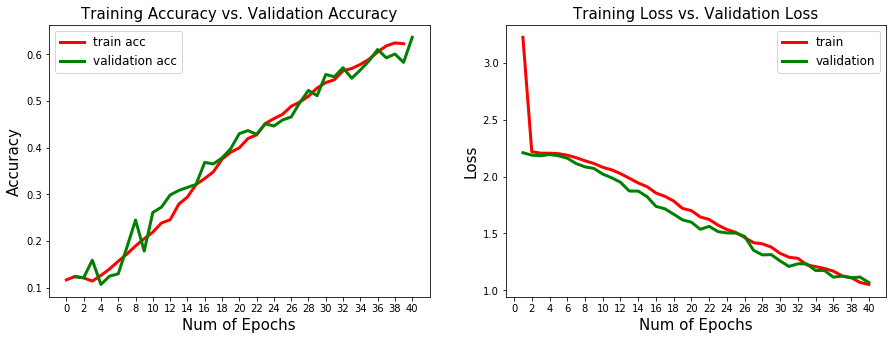

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 5))
  
# summarize history for accuracy
plt.subplot(1, 2 ,1)
plt.plot(np.arange(0, len(history.history['acc'])), acc, 'r', linewidth=3)
plt.plot(np.arange(1, len(history.history['val_acc'])+1), val_acc, 'g', linewidth=3)
plt.xticks(np.arange(0, 40+1, 2))
plt.title('Training Accuracy vs. Validation Accuracy', fontsize = 15)
plt.xlabel('Num of Epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend(['train acc', 'validation acc', 'train loss', 'validation loss'], loc='best', fontsize='large')
  
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(history.history['loss'])+1), history.history['loss'], 'r', linewidth=3)
plt.plot(np.arange(1, len(history.history['val_loss'])+1), history.history['val_loss'], 'g', linewidth=3)
plt.xticks(np.arange(0, 40+1, 2))
plt.title('Training Loss vs. Validation Loss', fontsize = 15)
plt.xlabel('Num of Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(['train', 'validation'], loc='best', fontsize='large')
  
plt.show()

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

for i in range(len(acc)):
    acc[i] = '{:.4}'.format(acc[i])
    val_acc[i] = '{:.4}'.format(val_acc[i])
    loss[i] = '{:.4}'.format(loss[i])
    val_loss[i] = '{:.4}'.format(val_loss[i])
    
d = {'acc': acc, 'val_acc': val_acc, 
     'loss': loss, 'val_loss': val_loss}
df = pd.DataFrame(data=d)
print(df)

# print("acc \t\t val_acc \t loss \t val_loss")
# print("------------------------------------------------------------------")

# for i in range(len(acc)):
#     print('{:.4}'.format(acc[i]), " \t", '{:.4}'.format(val_acc[i]), "\t", 
#           '{:.4}'.format(loss[i]), "\t", '{:.4}'.format(val_loss[i]))

       acc val_acc   loss val_loss
0   0.1169  0.1234  3.222    2.209
1   0.1243  0.1218  2.218    2.188
2    0.121  0.1591  2.205    2.182
3   0.1144  0.1071  2.205    2.193
4   0.1265   0.125  2.201    2.182
5   0.1404  0.1299  2.187    2.161
6   0.1568  0.1867  2.165    2.114
7   0.1722  0.2451  2.139    2.085
8   0.1896  0.1786  2.114    2.071
9    0.205  0.2614  2.081    2.022
10  0.2193  0.2727  2.059    1.989
11  0.2388  0.2987  2.026     1.95
12  0.2456  0.3084  1.985    1.873
13  0.2791  0.3149  1.943    1.872
14  0.2943  0.3214  1.911    1.823
15  0.3212  0.3685  1.855    1.738
16  0.3339  0.3653  1.827    1.717
17  0.3484  0.3782  1.785    1.669
18  0.3754  0.3977   1.72    1.619
19  0.3903  0.4302    1.7    1.599
20  0.3997  0.4367  1.645    1.537
21  0.4198  0.4286  1.623    1.563
22  0.4274  0.4513  1.573    1.517
23  0.4516  0.4464  1.535    1.505
24  0.4623  0.4594  1.509    1.504
25  0.4715  0.4659  1.465    1.475
26  0.4887  0.4968   1.42    1.353
27  0.4978  0.5227  

In [25]:
y_img_batch, y_class_batch = test_generator[0] 

for i in range(1,len(test_generator)):
    testX = test_generator[i][0]
    testY = test_generator[i][1]
    y_img_batch = np.concatenate((y_img_batch, testX))
    y_class_batch = np.concatenate((y_class_batch, testY))

y_pred = np.argmax(model.predict(y_img_batch),-1)
y_true = np.argmax(y_class_batch,-1)

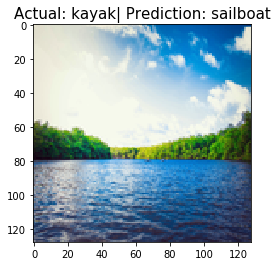

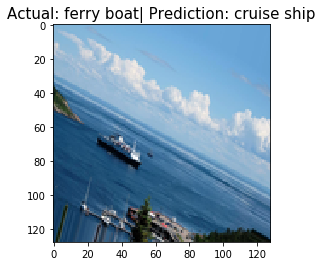

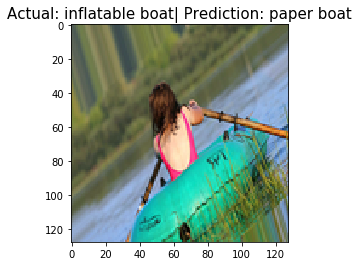

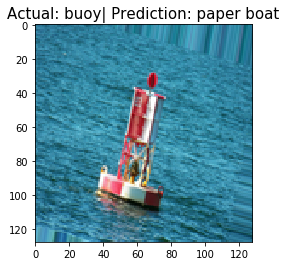

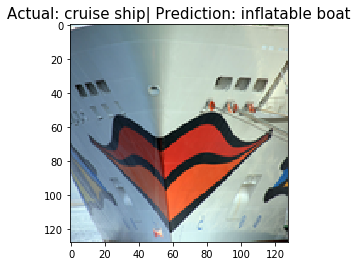

In [23]:
# for i in range(100):
#     plt.imshow((y_img_batch[i]*255))
#     actual_label = class_label[y_true[i]]
#     predict_label = class_label[y_pred[i]]
#     plt.title("Actual: " + actual_label + "| Prediction: " + predict_label, fontsize = 15)
#     plt.show()

counterC = 0
counterI = 0
i = 10
print('Incorrect Predictions: ')
while counterI < 5:
    actual_label = class_label[y_true[i]]
    predict_label = class_label[y_pred[i]]
    if (actual_label != predict_label):
        plt.imshow((y_img_batch[i]*255))
        plt.title("Actual: " + actual_label + "| Prediction: " + predict_label, fontsize = 15)
        plt.show()
        counterI+=1
        i+=1
    else:
        i+=1
     
print('Correct Predictions: ')
while counterC < 5:
    actual_label = class_label[y_true[i]]
    predict_label = class_label[y_pred[i]]
    if (actual_label == predict_label):
        plt.imshow((y_img_batch[i]*255))
        plt.title("Actual: " + actual_label + "| Prediction: " + predict_label, fontsize = 15)
        plt.show()
        counterC+=1
        i+=1
    else:
        i+=1

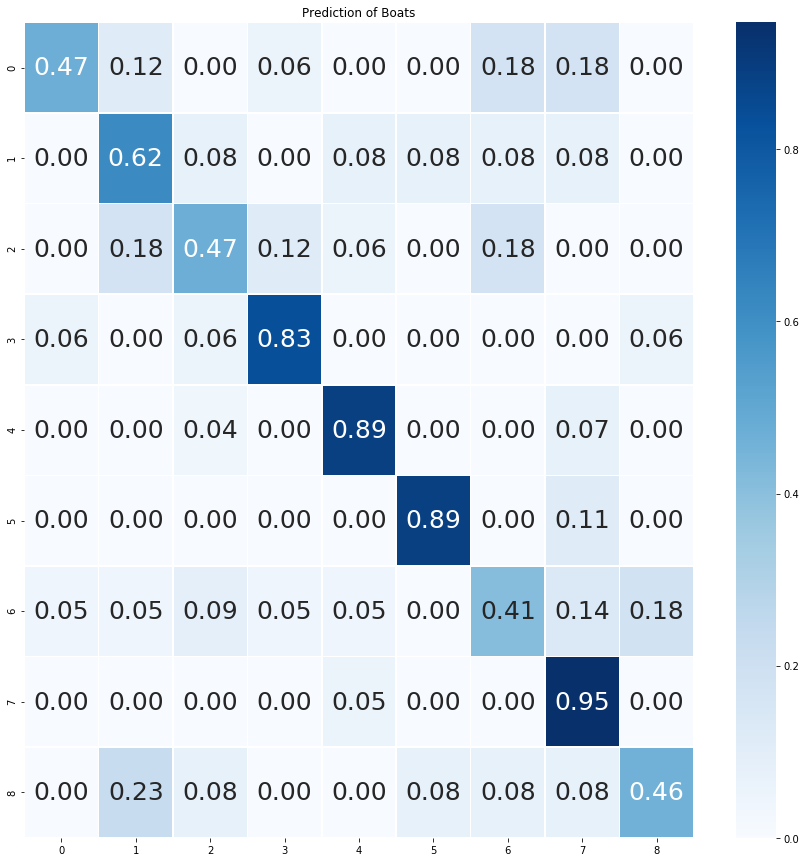

In [26]:
cm = confusion_matrix(y_true, y_pred) 
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(15,15))
plt.title('Prediction of Boats', fontsize = 25)
sns.heatmap(cmn, annot=True, fmt=".2f", linewidths=.5, cmap="Blues", annot_kws={"size": 25})

In [27]:
print(classification_report(y_true, y_pred, target_names=class_label))

                 precision    recall  f1-score   support

           buoy       0.80      0.47      0.59        17
    cruise ship       0.47      0.62      0.53        13
     ferry boat       0.57      0.47      0.52        17
   freight boat       0.79      0.83      0.81        18
        gondola       0.86      0.89      0.87        27
inflatable boat       0.80      0.89      0.84         9
          kayak       0.53      0.41      0.46        22
     paper boat       0.62      0.95      0.75        19
       sailboat       0.55      0.46      0.50        13

       accuracy                           0.67       155
      macro avg       0.66      0.67      0.65       155
   weighted avg       0.67      0.67      0.66       155



In [28]:
from sklearn import preprocessing
from scipy import interp
from itertools import cycle

n_classes = len(class_label)
lb = preprocessing.LabelBinarizer()
lb.fit(y_test)
y_true = lb.transform(y_true)
y_pred = lb.transform(y_pred)

lw = 5

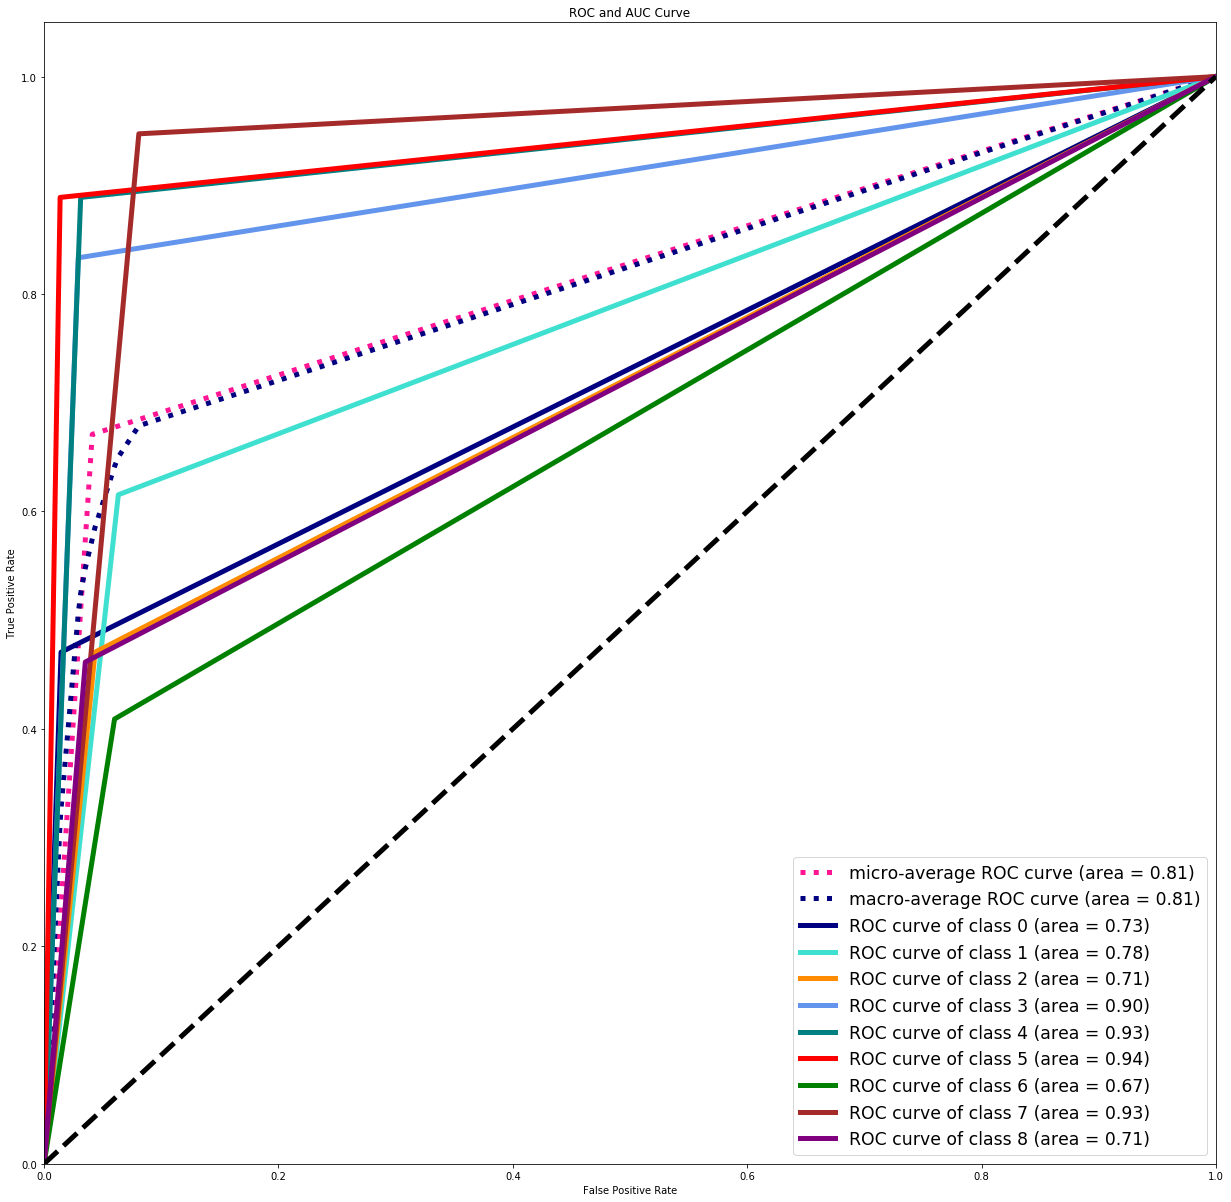

ROC_AUC_Score: 0.8118849436481919


In [29]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    
#     # Plot of a ROC curve for a specific class
#     for i in range(n_classes):
#         plt.figure(figsize=(15,15))
#         plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
#         plt.plot([0, 1], [0, 1], 'k--')
#         plt.xlim([0.0, 1.0])
#         plt.ylim([0.0, 1.05])
#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.title('Receiver operating characteristic example')
#         plt.legend(loc="lower right")
#         plt.show()


    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(21,21))
    plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=lw)

    plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=lw)

    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'green', 'brown', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
            label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize = 25)
    plt.ylabel('True Positive Rate', fontsize = 25)
    plt.title('ROC and AUC Curve', fontsize = 25)
    plt.legend(loc="lower right",fontsize='xx-large')
    plt.show()
        
    return roc_auc_score(y_test, y_pred, average=average)

print("ROC_AUC_Score:", multiclass_roc_auc_score(y_true, y_pred))

In [30]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
    
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i],
                                                        y_pred[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_true.ravel(),
    y_pred.ravel())
average_precision["micro"] = average_precision_score(y_true, y_pred,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.4f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.4868


Text(0.5,1,'Average precision score, micro-averaged over all classes: AP=0.4868')

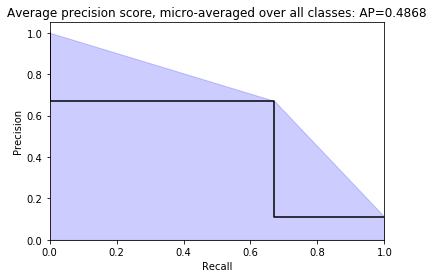

In [31]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='black', alpha=1.0,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='blue')#,
                 #**step_kwargs)

plt.xlabel('Recall', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.4f}'
    .format(average_precision["micro"]), fontsize = 15)

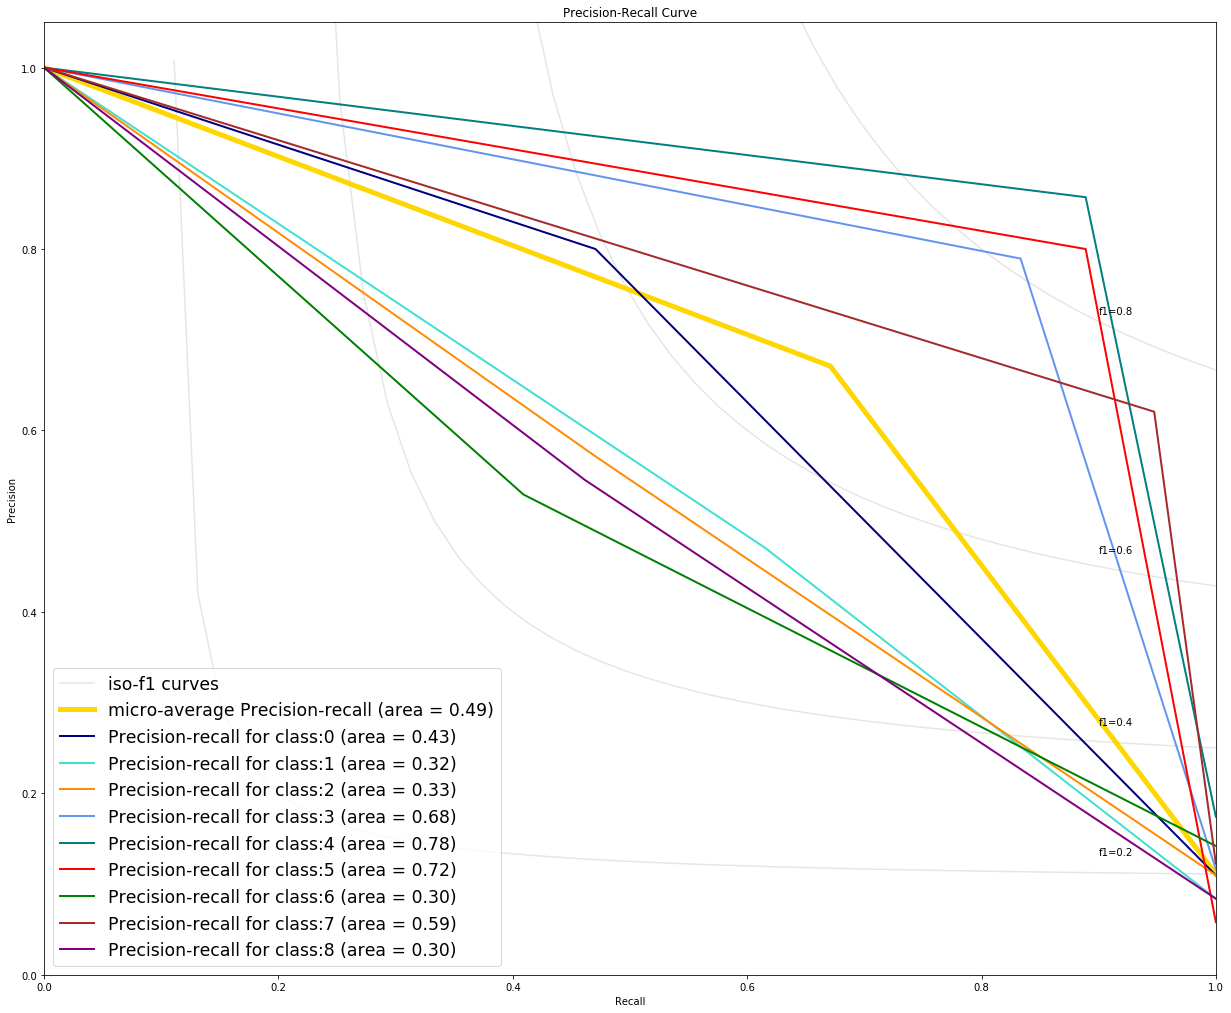

In [32]:
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'green', 'brown', 'purple'])

plt.figure(figsize=(21, 21))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=lw)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class:{0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize = 25)
plt.ylabel('Precision', fontsize = 25)
plt.title('Precision-Recall Curve', fontsize = 25)
plt.legend(lines, labels, loc='lower left', fontsize='xx-large')


plt.show()